grab libraries you need

Bring in libraries

In [ ]:
from pathlib import Path

import pandas as pd
from pandas import read_csv
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from datetime import  timedelta

import scipy.stats
from scipy import stats
from scipy.stats import pearsonr

import random

from matplotlib.ticker import ScalarFormatter


Create the simresult and outlierttrack classes

In [459]:
class SimResult:
    """This class stores the parameter description for, results of a simulation run.  """
    def __init__(self, test_descrip, results):
        self.test_descrip = test_descrip
        self.results = results

class OutlierTrack:
    """This class stores the outliers for a given store.  """
    def __init__(self, store, outlier_dates):
        self.store = store
        self.outlier_dates = outlier_dates

Date Parsing function

In [11]:
from dateutil import parser #date parsing function

def parse_date(date_str):
    try:
        return parser.parse(date_str, dayfirst=True)
    except ValueError:
        # Handle cases where parsing fails
        return pd.NaT

In [ ]:
Various forms of trend chart

In [469]:
def trend_chart(sales_dataframe, category, store_set, trend_line=False):
    """Take in a sales dataframe and category name, plot the trend chart as a line graph with weekly average sales"""
    # Ensure the DataFrame has the necessary columns
    if 'Date' not in sales_dataframe.columns or 'Weekly_Sales' not in sales_dataframe.columns:
        raise ValueError("DataFrame must contain 'Date' and 'Weekly_Sales' columns.")
    
    # Convert 'Date' column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(sales_dataframe['Date']):
        sales_dataframe['Date'] = pd.to_datetime(sales_dataframe['Date'])
    
    # Ensure the 'Date' column is set to the start of the week
    sales_dataframe['Date'] = sales_dataframe['Date'] - pd.to_timedelta(sales_dataframe['Date'].dt.weekday, unit='d')
    
    # Group by 'Date' and calculate the mean 'Weekly_Sales' for each week
    weekly_sales = sales_dataframe.groupby('Date')['Weekly_Sales'].mean().reset_index()

    #create trend line if requested
    # Calculate the line of best fit
    if trend_line:
        weekly_sales['Date_num'] = pd.to_numeric(weekly_sales['Date'])
        coefficients = np.polyfit(weekly_sales['Date_num'], weekly_sales['Weekly_Sales'], 1)
        poly = np.poly1d(coefficients)
        weekly_sales['Trendline'] = poly(weekly_sales['Date_num'])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(weekly_sales['Date'], weekly_sales['Weekly_Sales'], label = 'Weekly Sales', color='blue', marker='o', linestyle='-')
    if trend_line:
        plt.plot(weekly_sales['Date'], weekly_sales['Trendline'], label='Line of Best Fit', linestyle='--', color='black')
    plt.title(f"Sales Time Series: {store_set}", fontsize=14)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel(f"Sales: {category}", fontsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    
    # Ensure y-axis displays integer values with dollar signs
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${int(x):,}'))
    plt.tight_layout()
    plt.show()



def outlier_trend_chart(sales_dataframe, category, store_set, outlier_date, trend_line=False):
    """Take in a sales dataframe, category name, store set, and outlier date, plot the trend chart as a line graph with weekly average sales."""
    
    # Ensure the DataFrame has the necessary columns
    if 'Date' not in sales_dataframe.columns or 'Weekly_Sales' not in sales_dataframe.columns:
        raise ValueError("DataFrame must contain 'Date' and 'Weekly_Sales' columns.")
    
    # Convert 'Date' column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(sales_dataframe['Date']):
        sales_dataframe['Date'] = pd.to_datetime(sales_dataframe['Date'])
    
    # Ensure the 'Date' column is set to the start of the week
    sales_dataframe['Date'] = sales_dataframe['Date'] - pd.to_timedelta(sales_dataframe['Date'].dt.weekday, unit='d')
    
    # Group by 'Date' and calculate the mean 'Weekly_Sales' for each week
    weekly_sales = sales_dataframe.groupby('Date')['Weekly_Sales'].mean().reset_index()

    # Convert outlier_date to datetime if it's not already
    outlier_date = pd.to_datetime(outlier_date)
    
    # Create trend line if requested
    if trend_line:
        weekly_sales['Date_num'] = pd.to_numeric(weekly_sales['Date'])
        coefficients = np.polyfit(weekly_sales['Date_num'], weekly_sales['Weekly_Sales'], 1)
        poly = np.poly1d(coefficients)
        weekly_sales['Trendline'] = poly(weekly_sales['Date_num'])
    
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(weekly_sales['Date'], weekly_sales['Weekly_Sales'], label='Weekly Sales', color='blue', marker='o', linestyle='-')
    
    # Highlight the outlier date
    if outlier_date in weekly_sales['Date'].values:
        outlier_sales = weekly_sales[weekly_sales['Date'] == outlier_date]['Weekly_Sales'].values[0]
        plt.plot(outlier_date, outlier_sales, 'ro', label='Outlier')

    if trend_line:
        plt.plot(weekly_sales['Date'], weekly_sales['Trendline'], label='Line of Best Fit', linestyle='--', color='black')
    
    plt.title(f"Sales Time Series: {store_set}", fontsize=14)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel(f"Sales: {category}", fontsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    
    # Ensure y-axis displays integer values with dollar signs
    ax = plt.gca()
    ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${int(x):,}'))
    plt.tight_layout()
    plt.show()


def outlier_trend_chart_comparison(sales_dataframe, comparison_dataframe, category, store_set, outlier_dates, trend_line=False):
    """Plot sales trend chart with outliers for a store along with a comparison store's sales trend."""

    # Ensure the DataFrame has the necessary columns
    for df in [sales_dataframe, comparison_dataframe]:
        if 'Date' not in df.columns or 'Weekly_Sales' not in df.columns:
            raise ValueError("Both DataFrames must contain 'Date' and 'Weekly_Sales' columns.")
    
    # Convert 'Date' columns to datetime if they're not already
    for df in [sales_dataframe, comparison_dataframe]:
        if not pd.api.types.is_datetime64_any_dtype(df['Date']):
            df['Date'] = pd.to_datetime(df['Date'])
    
    # Ensure the 'Date' columns are set to the start of the week
    for df in [sales_dataframe, comparison_dataframe]:
        df['Date'] = df['Date'] - pd.to_timedelta(df['Date'].dt.weekday, unit='d')
    
    # Group by 'Date' and calculate the mean 'Weekly_Sales' for each week
    weekly_sales = sales_dataframe.groupby('Date')['Weekly_Sales'].mean().reset_index()
    weekly_comparison = comparison_dataframe.groupby('Date')['Weekly_Sales'].mean().reset_index()

    # Convert outlier_dates to datetime if they're not already
    outlier_dates = pd.to_datetime(outlier_dates)
        
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(weekly_sales['Date'], weekly_sales['Weekly_Sales'], label= f'{store_set} Sales', color='blue', marker='o', linestyle='-')
    plt.plot(weekly_comparison['Date'], weekly_comparison['Weekly_Sales'], label='Network Avg Sales', color='gray', marker='o', linestyle='-')
    
    # Highlight the outlier dates    
    for outlier_date in outlier_dates:
        if outlier_date in weekly_sales['Date'].values:
            outlier_weekly_sales = weekly_sales[weekly_sales['Date'] == outlier_date]['Weekly_Sales'].values[0]
            plt.plot(outlier_date, outlier_weekly_sales, 'ro')

    # Add a single legend entry for outliers
    plt.plot([], [], 'ro', label='Outlier')
    
    # Plot trend lines if requested
    if trend_line:
        plt.plot(weekly_sales['Date'], weekly_sales['Trendline'], label='Line of Best Fit', linestyle='--', color='black')
        plt.plot(weekly_comparison['Date'], weekly_comparison['Trendline'], label='Comparison Trendline', linestyle='--', color='darkgray')
    
    plt.title(f"Sales Time Series: {store_set}", fontsize=14)
    plt.xlabel("Date", fontsize=14)
    plt.ylabel(f"Sales Index to Avg: {category}", fontsize=14)
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    
    # Ensure y-axis displays integer values with dollar signs
    ax = plt.gca()
    plt.tight_layout()
    plt.show()




Making random test and control selections for simulator

In [13]:
def create_random_test_stores(stores_df, num_test=5):
    """Creates a set of randomly selected test stores.  Returns a dataframe of test stores 
    and a dataframe of the remaining stores referred to as control sites
    num_test is the number of random test stores to select.  It defaults to 5
    """
    all_stores = list(set(stores_df['Store']))
    random_test_list = []
    #make random test selections
    while True:
        random_store = random.choice(all_stores)
        if(random_store not in random_test_list):
            random_test_list.append(random_store)
        if(len(random_test_list)>=num_test):
            break
    test_sites = pd.DataFrame(random_test_list)
    test_sites.columns = ['Store']
    #create an all stores list and remove test sites from the list to make control
    all_stores_df = pd.DataFrame(list(set(stores_df['Store'])))
    all_stores_df.columns = ['Store']
    control_sites = pd.merge(all_stores_df['Store'], test_sites['Store'], how='outer', indicator=True)
    control_sites = control_sites.loc[control_sites._merge == 'left_only', ['Store']]
    test_sites.columns = ['target_store']
    control_sites.columns = ['control_pool_store']
    return(test_sites, control_sites)




In [ ]:
simulator, measurement, simsites functions

In [356]:
#simulator, measurement, similar sites

def similar_sites_pairing_correlmin(site_pair_scores, test_sites, control_sites, correl_min, max_simsites, min_simsites):
    """Pass in a list of site pair scores, the list of test stores, the list of control stores and
    return a dataframe of test site and control site matches.  
    Can match > 1 control site per test site.  Can re-use conntrol sites.  
    correl_min = minimum acceptable fit score between test and control stores.  between 0 and 1.
    max_simsites = maximum acceptable count of control stores per test store 
    min_simsites = minimum acceptable countn of control stores per test store.  Over-rides the minimum acceptable fit.
    """
    match_df = pd.DataFrame()
    for target_store in test_sites['target_store'].unique():
        store_slice = site_pair_scores[site_pair_scores['target_store'] == target_store].copy()
        
        # Remove target/test stores from the pool of controls
        control_store_set = set(control_sites['control_pool_store'])
        store_slice = store_slice[store_slice['paired_store'].isin(control_store_set)]
        
        # Order control from best to worst match
        sorted_slice = store_slice.sort_values(by='correlation', ascending=False)
        
        simsites = 0
        while not sorted_slice.empty and (simsites < max_simsites) and (simsites < min_simsites or sorted_slice.iloc[0]['correlation'] > correl_min):
            best_match = sorted_slice.iloc[0]
            match_df = pd.concat([match_df, best_match.to_frame().T])
            sorted_slice = sorted_slice.iloc[1:]
            simsites += 1
        
        if sorted_slice.empty and simsites < min_simsites:
            print(f"Unable to find a sufficient number of similar sites for {target_store}.")
    
    return match_df

def similar_sites_pairing(site_pair_scores, test_sites, control_sites, pairing_num):
    """Pass in a list of site pair scores, the list of test stores, the list of control stores
    return a dataframe of test site and control site matches.  
    Can match > 1 control site per test site.  Can re-use conntrol sites.  
    pairing_num is the number of control sites to assign to each test site.  
    """
    match_df = pd.DataFrame()
    for target_store in test_sites['target_store'].unique():
        store_slice = site_pair_scores[site_pair_scores['target_store'] == target_store].copy()
        
        # Remove target stores from the pool of controls
        control_store_set = set(control_sites['control_pool_store'])
        store_slice = store_slice[store_slice['paired_store'].isin(control_store_set)]
        
        # Get the top N pairings
        sorted_slice = store_slice.sort_values(by='correlation', ascending=False).head(pairing_num)
        match_df = pd.concat([match_df, sorted_slice])
    
    return match_df


def store_sales_similarity(store_sales, start_date, end_date, correl_weight):
    """Pass this function a dataframe of stores sales and dates. Will score the similarity of every site against every 
    other site for the timeframe specfied between the start date and end date
    correl_weight - indicates the relative influenc of correlation or trend_slope on the match score. correl_weight of 0 means 100% trend match.
    """
    #select data during the desired period
    data_time_slice = store_sales[(store_sales['Date'] >= start_date) & (store_sales['Date'] <= end_date)].copy()
    data_time_slice.sort_values(by=['Date'], inplace=True)
    #select the list of all stores in the data
    store_nums = data_time_slice['Store'].unique()
    
    results = []
    #nested loop - every store is compared with every other store
    for target_store in store_nums:
        target_store_slice = data_time_slice[data_time_slice['Store'] == target_store].copy()
        target_slope, target_intercept = np.polyfit(np.arange(len(target_store_slice)), target_store_slice['Weekly_Sales'], 1)
        target_slope = target_slope / target_store_slice['Weekly_Sales'].mean()
        
        for paired_store in store_nums:
            if target_store != paired_store:
                paired_store_slice = data_time_slice[data_time_slice['Store'] == paired_store].copy()
                #the slope of line of best fit is the trend used in the slope part of matching
                paired_slope, paired_intercept = np.polyfit(np.arange(len(paired_store_slice)), paired_store_slice['Weekly_Sales'], 1)
                paired_slope = paired_slope / paired_store_slice['Weekly_Sales'].mean()

                slope_score = 1 - abs(target_slope - paired_slope)
                #correlation between each sites sales trend over the selected period
                correl_result = stats.pearsonr(target_store_slice['Weekly_Sales'], paired_store_slice['Weekly_Sales'])[0]
                #overall match is a weighted funnction of correlation and slope, weight depends on the correl_weight variable
                match_score = correl_weight * correl_result + (1-correl_weight) * slope_score
                results.append((target_store, paired_store, match_score))
    
    site_pair_scores = pd.DataFrame(results, columns=['target_store', 'paired_store', 'correlation'])
    return site_pair_scores



def measurement(match_df, sales_df, pre_period_start, pre_period_end, post_period_start, post_period_end):
    """Measures the impact of tests.  
    input is the test and control matches dataframe, the sales dataframe, and timeframes for the analysis.
    output is a lift and p-value calculation
    """
    # Precompute slices
    pre_slice = sales_df[(sales_df['Date'] >= pre_period_start) & (sales_df['Date'] <= pre_period_end)].copy()
    post_slice = sales_df[(sales_df['Date'] >= post_period_start) & (sales_df['Date'] <= post_period_end)].copy()

    # Initialize lists for results
    pre_values_test = []
    post_values_test = []
    pre_values_control = []
    post_values_control = []
    expected_values = []

    # Get unique test stores
    test_stores = match_df['target_store'].unique()

    for target_store in test_stores:
        # Calculate test store sales
        store_pre_slice = pre_slice[pre_slice['Store'] == target_store]
        store_post_slice = post_slice[post_slice['Store'] == target_store]
        pre_sales_test = store_pre_slice['Weekly_Sales'].mean()
        post_sales_test = store_post_slice['Weekly_Sales'].mean()
        pre_values_test.append(pre_sales_test)
        post_values_test.append(post_sales_test)

        # Calculate control store sales
        store_control_list = match_df[match_df['target_store'] == target_store]
        control_stores = store_control_list['paired_store'].unique()
        
        control_pre_sales = pre_slice[pre_slice['Store'].isin(control_stores)].groupby('Store')['Weekly_Sales'].mean()
        control_post_sales = post_slice[post_slice['Store'].isin(control_stores)].groupby('Store')['Weekly_Sales'].mean()
        
        pre_avg_control = control_pre_sales.mean()
        post_avg_control = control_post_sales.mean()
        
        pre_values_control.append(pre_avg_control)
        post_values_control.append(post_avg_control)
        
        # Calculate expected values
        expected_values.append(pre_sales_test * (post_avg_control / pre_avg_control))
    
    # Statistical test
    t, p = stats.ttest_rel(post_values_test, expected_values)
    
    # Calculate lift
    lift = (sum(post_values_test) - sum(expected_values)) / sum(expected_values)
    
    return lift, p


def simulator(sales_df, test_plan_df, pre_length, post_length, num_iterations=1, num_test_sites=5):
    """Runs simulations for a provided set of test plans provided through a dataframe.  A sales dataframe is also passed.
    
    Returns a list of SimResult class objects

    Test plan df has the following columns: 
        correl_min = minimum acceptable fit score between test and control stores.  between 0 and 1.
        max_simsites = maximum acceptable count of control stores per test store 
        min_simsites = minimum acceptable countn of control stores per test store.  Over-rides the minimum acceptable fit.
        correl_weight = How influential is correlation to the fit score relative to trend line similarity.  between 0 and 1
        match_type = determines if the minimum correlation approach is used, or if the same number of simsites are selected 
        regardless of fit quality.  select the min correlation approach with a value of min_correl

    Additional simulator specifications are passed as arguments to this function directly
    pre length = pre period length in days
    post length = post period length in days
    num_iterations = how many monte carlo simulations per row of the test plan
    Num test sites = how many test sites to select per simulation run
    """
    
    # potentially limit date selection to ensure similar timing with TYLY version
    yoy_match_timing = timedelta(days=364)

    # Determine viable dates
    results = []
    dates_df = pd.DataFrame(sales_df['Date'].unique(), columns=['Date']).sort_values(by='Date')
    stores_df = pd.DataFrame(sales_df['Store'].unique(), columns=['Store'])
    
    min_date = dates_df['Date'].iloc[0]
    max_date = dates_df['Date'].iloc[-1]
    pre_length = timedelta(days=int(pre_length))
    post_length = timedelta(days=int(post_length))

    for idx, row in test_plan_df.iterrows():
        match_length = timedelta(days=int(row['match_length']))
        min_pre_start = min_date + max(match_length, yoy_match_timing)
        max_pre_start = max_date - post_length - pre_length

        if max_pre_start < min_pre_start:
            print(f"There are no viable dates where pre_length is {pre_length}, match length is {match_length}, \
                  and post length is {post_length}")
            continue

        viable_pre_start_df = dates_df[(dates_df['Date'] > min_pre_start) & (dates_df['Date'] < max_pre_start)]
        measurement_list = []
        
        correl_min = row['correl_min']
        max_simsites = row['max_simsites']
        min_simsites = row['min_simsites']
        correl_weight = row['correl_weight']
        match_type = row['match_type']
        
        for i in range(num_iterations):
            print(f"plan iteration {idx} sim iteration {i}")
            
            # Grab random start date
            pre_start_date = viable_pre_start_df.sample(1).iloc[0, 0]
            
            # Grab random test and control stores
            test_sites, control_sites = create_random_test_stores(stores_df, num_test=num_test_sites)
            
            # Run the matching functions
            site_pair_scores = store_sales_similarity(sales_df, pre_start_date + pre_length - match_length, 
                                                      pre_start_date + pre_length, correl_weight)
            
            if match_type == "min_correl":
                sim_sites = similar_sites_pairing_correlmin(site_pair_scores, test_sites, control_sites, 
                                                            correl_min, max_simsites, min_simsites)
            else:
                sim_sites = similar_sites_pairing(site_pair_scores, test_sites, control_sites, max_simsites)
            
            # Measure lift
            time_between_pre_post = timedelta(days=1)
            lift, p = measurement(sim_sites, sales_df, pre_start_date, pre_start_date + pre_length, 
                                    pre_start_date + pre_length + time_between_pre_post, pre_start_date + pre_length + 
                                    time_between_pre_post + post_length)
            measurement_list.append(lift)
        
        test_plan_string = f"correl_min: {correl_min}, max_simsites {max_simsites}, min_simsites {min_simsites}, \
        match_length {row['match_length']}"
        results.append(SimResult(test_descrip=test_plan_string, results=measurement_list))
    
    return results

TYLY versions of simulator, measurement, simsites

In [299]:
#tyly functions
def simulator_tyly(sales_df, test_plan_df, pre_length, post_length, num_iterations=1, num_test_sites=5):
    """Runs simulations for a provided list. test plan df has columns: correl_min, max_simsites, min_simsites"""
    # Determine viable dates
    results = []
    dates_df = pd.DataFrame(sales_df['Date'].unique(), columns=['Date']).sort_values(by='Date')
    stores_df = pd.DataFrame(sales_df['Store'].unique(), columns=['Store'])
    time_between_pre_post = timedelta(days=1)
    min_date = dates_df['Date'].iloc[0]
    max_date = dates_df['Date'].iloc[-1]
    pre_length = timedelta(days=int(pre_length))
    post_length = timedelta(days=int(post_length))

    for idx, row in test_plan_df.iterrows():
        ly_length = timedelta(days=int(364))
        min_pre_start = min_date + ly_length 
        max_pre_start = max_date - post_length - pre_length - time_between_pre_post

        if max_pre_start < min_pre_start:
            print(f"There are no viable dates where pre_length is {pre_length}, and post length is {post_length}")
            continue

        viable_pre_start_df = dates_df[(dates_df['Date'] > min_pre_start) & (dates_df['Date'] < max_pre_start)]
        measurement_list = []
        
        max_simsites = row['simsites']
  
        for i in range(num_iterations):
            print(f"plan iteration {idx} sim iteration {i}")
            
            # Grab random start date
            pre_start_date = viable_pre_start_df.sample(1).iloc[0, 0]
            
            # Grab random test and control stores
            test_sites, control_sites = create_random_test_stores(stores_df, num_test=num_test_sites)
            
            # Run the matching functions
            site_pair_scores = store_sales_similarity_tyly(sales_df, pre_start_date, pre_start_date + pre_length, pre_start_date + time_between_pre_post + pre_length, pre_start_date + pre_length + post_length + time_between_pre_post)
            sim_sites = similar_sites_pairing(site_pair_scores, test_sites, control_sites, max_simsites)
            
            # Measure lift
            lift, p = measurement_tyly(sim_sites, sales_df, pre_start_date, pre_start_date + pre_length, pre_start_date + pre_length + time_between_pre_post, pre_start_date + pre_length + time_between_pre_post + post_length)
            measurement_list.append(lift)
            print(f"Lift: {lift}")
        
        test_plan_string = f" simsites: {max_simsites}"
        results.append(SimResult(test_descrip=test_plan_string, results=measurement_list))
    
    return results

def simulator_tyly_match_prepost_measure(sales_df, test_plan_df, pre_length, post_length, num_iterations=1, num_test_sites=5):
    """Runs simulations for a provided set of test plans provided through a dataframe.  A sales dataframe is also passed.
    
    Returns a list of SimResult class objects

    Test plan df has the following columns: 
        correl_min = minimum acceptable fit score between test and control stores.  between 0 and 1.
        max_simsites = maximum acceptable count of control stores per test store 
        min_simsites = minimum acceptable countn of control stores per test store.  Over-rides the minimum acceptable fit.
        correl_weight = How influential is correlation to the fit score relative to trend line similarity.  between 0 and 1
        match_type = determines if the minimum correlation approach is used, or if the same number of simsites are selected 
        regardless of fit quality.  select the min correlation approach with a value of min_correl

    Additional simulator specifications are passed as arguments to this function directly
    pre length = pre period length in days
    post length = post period length in days
    num_iterations = how many monte carlo simulations per row of the test plan
    Num test sites = how many test sites to select per simulation run
    """
    # Determine viable dates
    results = []
    dates_df = pd.DataFrame(sales_df['Date'].unique(), columns=['Date']).sort_values(by='Date')
    stores_df = pd.DataFrame(sales_df['Store'].unique(), columns=['Store'])
    time_between_pre_post = timedelta(days=1)
    min_date = dates_df['Date'].iloc[0]
    max_date = dates_df['Date'].iloc[-1]
    pre_length = timedelta(days=int(pre_length))
    post_length = timedelta(days=int(post_length))

    for idx, row in test_plan_df.iterrows():
        ly_length = timedelta(days=int(364))
        min_pre_start = min_date + ly_length 
        max_pre_start = max_date - post_length - pre_length - time_between_pre_post

        if max_pre_start < min_pre_start:
            print(f"There are no viable dates where pre_length is {pre_length}, and post length is {post_length}")
            continue

        viable_pre_start_df = dates_df[(dates_df['Date'] > min_pre_start) & (dates_df['Date'] < max_pre_start)]
        measurement_list = []
        
        max_simsites = row['simsites']
  
        for i in range(num_iterations):
            print(f"plan iteration {idx} sim iteration {i}")
            
            # Grab random start date
            pre_start_date = viable_pre_start_df.sample(1).iloc[0, 0]
            
            # Grab random test and control stores
            test_sites, control_sites = create_random_test_stores(stores_df, num_test=num_test_sites)
            
            # Run the matching functions
            site_pair_scores = store_sales_similarity_tyly(sales_df, pre_start_date, pre_start_date + pre_length, pre_start_date + time_between_pre_post + pre_length, pre_start_date + pre_length + post_length + time_between_pre_post)
            sim_sites = similar_sites_pairing(site_pair_scores, test_sites, control_sites, max_simsites)
            
            # Measure lift
            lift, p = measurement(sim_sites, sales_df, pre_start_date, pre_start_date + pre_length, pre_start_date + pre_length + time_between_pre_post, pre_start_date + pre_length + time_between_pre_post + post_length)
            measurement_list.append(lift)
            print(f"Lift: {lift}")
        
        test_plan_string = f" simsites: {max_simsites}"
        results.append(SimResult(test_descrip=test_plan_string, results=measurement_list))
    
    return results

#tyly functions
def simulator_tyly(sales_df, test_plan_df, pre_length, post_length, num_iterations=1, num_test_sites=5):
    """Runs simulations for a provided set of test plans provided through a dataframe.  A sales dataframe is also passed.
    
    Returns a list of SimResult class objects.  They are measured using the TYLY approach.

    Test plan df has the following columns: 
    correl_min = minimum acceptable fit score between test and control stores.  between 0 and 1.
    max_simsites = maximum acceptable count of control stores per test store 
    min_simsites = minimum acceptable countn of control stores per test store.  Over-rides the minimum acceptable fit.
    correl_weight = How influential is correlation to the fit score relative to trend line similarity.  between 0 and 1
    match_type = determines if the minimum correlation approach is used, or if the same number of simsites are selected 
    regardless of fit quality.  select the min correlation approach with a value of min_correl

    Additional simulator specifications are passed as arguments to this function directly
    pre length = pre period length in days
    post length = post period length in days
    num_iterations = how many monte carlo simulations per row of the test plan
    Num test sites = how many test sites to select per simulation run
    """
    # Determine viable dates
    results = []
    dates_df = pd.DataFrame(sales_df['Date'].unique(), columns=['Date']).sort_values(by='Date')
    stores_df = pd.DataFrame(sales_df['Store'].unique(), columns=['Store'])
    time_between_pre_post = timedelta(days=1)
    min_date = dates_df['Date'].iloc[0]
    max_date = dates_df['Date'].iloc[-1]
    pre_length = timedelta(days=int(pre_length))
    post_length = timedelta(days=int(post_length))

    for idx, row in test_plan_df.iterrows():
        ly_length = timedelta(days=int(364))
        min_pre_start = min_date + ly_length 
        max_pre_start = max_date - post_length - pre_length - time_between_pre_post

        if max_pre_start < min_pre_start:
            print(f"There are no viable dates where pre_length is {pre_length}, and post length is {post_length}")
            continue

        viable_pre_start_df = dates_df[(dates_df['Date'] > min_pre_start) & (dates_df['Date'] < max_pre_start)]
        measurement_list = []
        
        max_simsites = row['simsites']
  
        for i in range(num_iterations):
            print(f"plan iteration {idx} sim iteration {i}")
            
            # Grab random start date
            pre_start_date = viable_pre_start_df.sample(1).iloc[0, 0]
            
            # Grab random test and control stores
            test_sites, control_sites = create_random_test_stores(stores_df, num_test=num_test_sites)
            
            # Run the matching functions
            site_pair_scores = store_sales_similarity_tyly(sales_df, pre_start_date, pre_start_date + pre_length, pre_start_date + time_between_pre_post + pre_length, pre_start_date + pre_length + post_length + time_between_pre_post)
            sim_sites = similar_sites_pairing(site_pair_scores, test_sites, control_sites, max_simsites)
            
            # Measure lift
            lift, p = measurement_tyly(sim_sites, sales_df, pre_start_date, pre_start_date + pre_length, pre_start_date + pre_length + time_between_pre_post, pre_start_date + pre_length + time_between_pre_post + post_length)
            measurement_list.append(lift)
            print(f"Lift: {lift}")
        
        test_plan_string = f" simsites: {max_simsites}"
        results.append(SimResult(test_descrip=test_plan_string, results=measurement_list))
    
    return results

def simulator_trends_match_TYLY_measure(sales_df, test_plan_df, pre_length, post_length, num_iterations=1, num_test_sites=5):
    """Runs simulations for a provided list. test plan df has columns: correl_min, max_simsites, min_simsites"""
    # Determine viable dates
    results = []
    dates_df = pd.DataFrame(sales_df['Date'].unique(), columns=['Date']).sort_values(by='Date')
    stores_df = pd.DataFrame(sales_df['Store'].unique(), columns=['Store'])
    time_between_pre_post = timedelta(days=1)
    min_date = dates_df['Date'].iloc[0]
    max_date = dates_df['Date'].iloc[-1]
    pre_length = timedelta(days=int(pre_length))
    post_length = timedelta(days=int(post_length))

    for idx, row in test_plan_df.iterrows():
        ly_length = timedelta(days=int(364))
        min_pre_start = min_date + ly_length 
        max_pre_start = max_date - post_length - pre_length - time_between_pre_post

        if max_pre_start < min_pre_start:
            print(f"There are no viable dates where pre_length is {pre_length}, and post length is {post_length}")
            continue

        viable_pre_start_df = dates_df[(dates_df['Date'] > min_pre_start) & (dates_df['Date'] < max_pre_start)]
        measurement_list = []
        
        max_simsites = row['simsites']
  
        for i in range(num_iterations):
            print(f"plan iteration {idx} sim iteration {i}")
            
            # Grab random start date
            pre_start_date = viable_pre_start_df.sample(1).iloc[0, 0]
            
            # Grab random test and control stores
            test_sites, control_sites = create_random_test_stores(stores_df, num_test=num_test_sites)
            
            # Run the matching functions
            site_pair_scores = store_sales_similarity(sales_df, pre_start_date, pre_start_date + pre_length, pre_start_date + time_between_pre_post + pre_length, pre_start_date + pre_length + post_length + time_between_pre_post)
            sim_sites = similar_sites_pairing(site_pair_scores, test_sites, control_sites, max_simsites)
            
            # Measure lift
            lift, p = measurement_TYLY(sim_sites, sales_df, pre_start_date, pre_start_date + pre_length, pre_start_date + pre_length + time_between_pre_post, pre_start_date + pre_length + time_between_pre_post + post_length)
            measurement_list.append(lift)
            print(f"Lift: {lift}")
        
        test_plan_string = f" simsites: {max_simsites}"
        results.append(SimResult(test_descrip=test_plan_string, results=measurement_list))
    
    return results


#reconstructed
def store_sales_similarity_tyly(store_sales, pre_start, pre_end, post_start, post_end):
    """Pass this function a dataframe of stores sales along with the start and end dates of pre and testing period
    The functiion will score site similarty on sales performance changes last year during the pre and post periods
    Returns similarity scores for every site pairing combination
    """
    ly_length = timedelta(days=int(364))
    data_time_slice_pre = store_sales[(store_sales['Date']  >= pre_start - ly_length ) & (store_sales['Date'] <= pre_end - ly_length )].copy()
    data_time_slice_post = store_sales[(store_sales['Date']  >= post_start - ly_length) & (store_sales['Date']  <= post_end - ly_length)].copy()
    store_nums = data_time_slice_pre['Store'].unique()
    
    results = []
    for target_store in store_nums:
        target_store_slice_pre = data_time_slice_pre[data_time_slice_pre['Store'] == target_store].copy()
        target_store_slice_post = data_time_slice_post[data_time_slice_post['Store'] == target_store].copy()
        for paired_store in store_nums:
            if target_store != paired_store:
                paired_store_slice_pre = data_time_slice_pre[data_time_slice_pre['Store'] == paired_store].copy()
                paired_store_slice_post = data_time_slice_post[data_time_slice_post['Store'] == paired_store].copy()
                match_score = 1-abs((target_store_slice_post['Weekly_Sales'].mean() / target_store_slice_pre['Weekly_Sales'].mean()) - (paired_store_slice_post['Weekly_Sales'].mean() / paired_store_slice_pre['Weekly_Sales'].mean()) )
                results.append((target_store, paired_store, match_score))
    
    site_pair_scores = pd.DataFrame(results, columns=['target_store', 'paired_store', 'correlation'])
    return site_pair_scores

def measurement_tyly(match_df, sales_df, pre_period_start, pre_period_end, post_period_start, post_period_end):
    """Measures the impact of test measured using TYLY approach
    input is the test and control matches dataframe, the sales dataframe, and timeframes for the analysis.
    output is a lift and p-value calculation
    """
    ly_length = timedelta(days=int(364))
    # Precompute slices
    pre_slice = sales_df[(sales_df['Date'] >= pre_period_start) & (sales_df['Date'] <= pre_period_end)].copy()
    post_slice = sales_df[(sales_df['Date'] >= post_period_start) & (sales_df['Date'] <= post_period_end)].copy()
    pre_slice_ly = sales_df[(sales_df['Date'] >= pre_period_start - ly_length) & (sales_df['Date'] <= pre_period_end - ly_length)].copy()
    post_slice_ly = sales_df[(sales_df['Date'] >= post_period_start - ly_length) & (sales_df['Date'] <= post_period_end - ly_length)].copy()

    # Initialize lists for results
    pre_values_test_list = []
    post_values_test_list = []
    pre_values_control_list = []
    post_values_control_list = []
    pre_values_test_ly_list = []
    post_values_test_ly_list = []
    pre_values_control_ly_list = []
    post_values_control_ly_list = []
    expected_values_list = []

    # Get unique test stores
    test_stores = match_df['target_store'].unique()

    for target_store in test_stores:
        # Calculate test store sales
        store_pre_slice = pre_slice[pre_slice['Store'] == target_store].copy()
        store_post_slice = post_slice[post_slice['Store'] == target_store].copy()
        store_pre_slice_ly = pre_slice_ly[pre_slice_ly['Store'] == target_store].copy()
        store_post_slice_ly = post_slice_ly[post_slice_ly['Store'] == target_store].copy()
        pre_sales_test = store_pre_slice['Weekly_Sales'].mean()
        post_sales_test = store_post_slice['Weekly_Sales'].mean()
        pre_sales_test_ly = store_pre_slice_ly['Weekly_Sales'].mean()
        post_sales_test_ly = store_post_slice_ly['Weekly_Sales'].mean()
        pre_values_test_list.append(pre_sales_test)
        post_values_test_list.append(post_sales_test)
        pre_values_test_ly_list.append(pre_sales_test_ly)
        post_values_test_ly_list.append(post_sales_test_ly)

        # Calculate control store sales
        store_control_list = match_df[match_df['target_store'] == target_store]
        control_stores = store_control_list['paired_store'].unique()
        
        control_pre_sales = pre_slice[pre_slice['Store'].isin(control_stores)].groupby('Store')['Weekly_Sales'].mean()
        control_post_sales = post_slice[post_slice['Store'].isin(control_stores)].groupby('Store')['Weekly_Sales'].mean()
        control_pre_sales_ly = pre_slice_ly[pre_slice_ly['Store'].isin(control_stores)].groupby('Store')['Weekly_Sales'].mean()
        control_post_sales_ly = post_slice_ly[post_slice_ly['Store'].isin(control_stores)].groupby('Store')['Weekly_Sales'].mean()
        
        pre_avg_control = control_pre_sales.mean()
        post_avg_control = control_post_sales.mean()
        pre_avg_control_ly = control_pre_sales_ly.mean()
        post_avg_control_ly = control_post_sales_ly.mean()
        
        pre_values_control_list.append(pre_avg_control)
        post_values_control_list.append(post_avg_control)
        pre_values_control_ly_list.append(pre_avg_control_ly)
        post_values_control_ly_list.append(post_avg_control_ly)
        
        # Calculate expected values
        expected_values_list.append(pre_sales_test * (post_sales_test_ly / pre_sales_test_ly) * ((post_avg_control / pre_avg_control) / (post_avg_control_ly / pre_avg_control_ly)))

    # Statistical test
    t, p = stats.ttest_rel(post_values_test_list, expected_values_list)
    
    # Calculate lift
    lift = (sum(post_values_test_list) - sum(expected_values_list)) / sum(expected_values_list)
    
    return lift, p




Code used to import the data

In [94]:
#import the dataset
dataset_retail = read_csv("/Users/jeffreycampbell/Desktop/python_work/retail_sample_data/retail_data.csv")
dataset_sales = read_csv("/Users/jeffreycampbell/Desktop/python_work/retail_sample_data/sales_data.csv")
dataset_stores = read_csv("/Users/jeffreycampbell/Desktop/python_work/retail_sample_data/stores_data.csv")
#dates are inconsistent - parse and convert to date format
dataset_sales['Date'] = dataset_sales['Date'].apply(parse_date)
dataset_retail['Date'] = dataset_retail['Date'].apply(parse_date)
#Convert sales to float
dataset_sales['Weekly_Sales'] = dataset_sales['Weekly_Sales'].astype(float)
#create a total store sales view
total_store_sales = pd.DataFrame()
total_store_sales = dataset_sales.groupby(['Date','Store'], as_index=False)['Weekly_Sales'].sum()
#create a chain sales view
chain_sales=dataset_sales.groupby(['Date'], as_index=False)['Weekly_Sales'].sum()

filepath = Path('/Users/jeffreycampbell/Desktop/python_work/retail_sample_data/total_store_data.csv') 
total_store_sales.to_csv(filepath, index=False)


Code used to remove outliers from the data

In [ ]:
#drop outliers from dataset
total_store_sales_no_outliers = total_store_sales.loc[(total_store_sales['Store'] != 35) & (total_store_sales['Store'] != 36)].copy()
total_store_sales_no_outliers['Weekly_Sales'].loc[(total_store_sales_no_outliers['Store'] == 18) & (total_store_sales_no_outliers['Date'] == '2011-08-29')] = total_store_sales_no_outliers['Weekly_Sales'].loc[(total_store_sales_no_outliers['Store'] == 18) & (total_store_sales_no_outliers['Date'] == '2011-08-29')] / 0.5


Simulation plans, outputs to a list of simresults objects

In [612]:
#create simulation scenarios and run them
test_plan_list = []
test_plan_list.append({"simsites" : [39]})

test_plan_df = pd.DataFrame()
for item in test_plan_list:
    test_plan_temp = pd.DataFrame(item)
    test_plan_df = pd.concat([test_plan_df,test_plan_temp], ignore_index=True)

print(test_plan_df)
results_list_tyly_site_BOC_5_test_stores_noout = simulator_tyly(total_store_sales_no_outliers, test_plan_df, pre_length=60, post_length=60, num_iterations=500, num_test_sites=5)
results_list_tyly_site_BOC_4_test_stores_noout = simulator_tyly(total_store_sales_no_outliers, test_plan_df, pre_length=60, post_length=60, num_iterations=500, num_test_sites=4)


/var/folders/d8/81qn_kfs39x88w0868hpns480000gn/T/ipykernel_39155/2099062576.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_store_sales_no_outliers['Weekly_Sales'].loc[(total_store_sales_no_outliers['Store'] == 18) & (total_store_sales_no_outliers['Date'] == '2011-08-29')] = total_store_sales_no_outliers['Weekly_Sales'].loc[(total_store_sales_no_outliers['Store'] == 18) & (total_store_sales_no_outliers['Date'] == '2011-08-29')] / 0.5


   simsites
0        39
plan iteration 0 sim iteration 0
Lift: -0.0009597641889961886
plan iteration 0 sim iteration 1
Lift: 0.02825530218648292
plan iteration 0 sim iteration 2
Lift: 0.015433014584056916
plan iteration 0 sim iteration 3
Lift: -0.01719128556294715
plan iteration 0 sim iteration 4
Lift: -0.011047385200864956
plan iteration 0 sim iteration 5
Lift: 0.00152444824468415
plan iteration 0 sim iteration 6
Lift: -0.005527528008614797
plan iteration 0 sim iteration 7
Lift: -0.04344459280915131
plan iteration 0 sim iteration 8
Lift: 0.003448217464042383
plan iteration 0 sim iteration 9
Lift: -0.009120222652934223
plan iteration 0 sim iteration 10
Lift: -0.0054132991605226315
plan iteration 0 sim iteration 11
Lift: -0.015232626120131714
plan iteration 0 sim iteration 12
Lift: 0.013574552840857257
plan iteration 0 sim iteration 13
Lift: 0.014682114158426626
plan iteration 0 sim iteration 14
Lift: 0.0014722397125526753
plan iteration 0 sim iteration 15
Lift: -0.016081317332253202
pl

display simulation results, and save the raw simulation data to a csv.

In [614]:
#summarize simulation results
results_df = pd.DataFrame()
barchart_df = pd.DataFrame()
for j in range(0, len(results_list_tyly_site_BOC_4_test_stores_noout)):
    temp_results_df = pd.DataFrame(results_list_tyly_site_BOC_4_test_stores_noout[j].results)
    temp_results_df.columns = [results_list_tyly_site_BOC_4_test_stores_noout[j].test_descrip]
    test_descrip = results_list_tyly_site_BOC_4_test_stores_noout[j].test_descrip
    results_df = pd.concat([results_df, temp_results_df], axis=1)
    test_stdev = temp_results_df.std(ddof=0).iloc[0]
    test_avg = temp_results_df.mean().iloc[0]
    #print(f"Params: {test_descrip}, \n    Test stdev {test_stdev}, test avg {test_avg}")
    barchart_df_temp_dict = {'Test_Params': [f"{test_descrip}"], 'stdev': [f"{test_stdev*100}"]}
    barchart_df_temp = pd.DataFrame(barchart_df_temp_dict)
    barchart_df = pd.concat([barchart_df, barchart_df_temp])
print(barchart_df)

filepath = Path('/Users/jeffreycampbell/Desktop/python_work/retail_sample_data/results_list_tyly_site_BOC_4_test_stores_noout.csv') 
results_df.to_csv(filepath, index=False)

     Test_Params               stdev
0   simsites: 39  1.3337500544248515


input past simulation results from a csv and summarize the findings

In [341]:
#input old simulation results from csv
results_df = read_csv("/Users/jeffreycampbell/Desktop/python_work/retail_sample_data/results_list_tyly_5testsite.csv")
#print(results_df)

result_cols = results_df.columns

barchart_df = pd.DataFrame()
for col in result_cols:
    #barchart_df_temp = {'Test_Params':[results_df[col].test_descrip], 'Stdev': [results_df.std(ddof=0)[0]]}
    print(results_df.std(ddof=0)[0])
    pd.concat(barchart_df, barchart_df_temp)

print(barchart_df)


0.014474211673873803


/var/folders/d8/81qn_kfs39x88w0868hpns480000gn/T/ipykernel_39155/2885651339.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(results_df.std(ddof=0)[0])


TypeError: concat() takes 1 positional argument but 2 were given

Histogram of store sales 

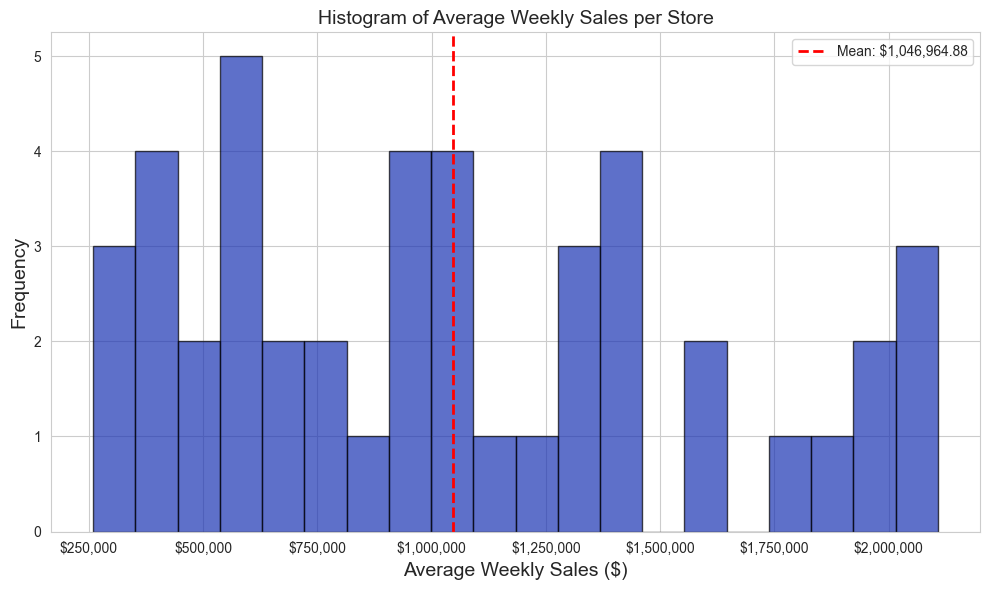

In [649]:
# Group by 'Store' and calculate the mean 'Weekly_Sales' for each store
average_weekly_sales = total_store_sales.groupby('Store')['Weekly_Sales'].mean().reset_index()

# Calculate the mean of the average weekly sales
mean_sales = average_weekly_sales['Weekly_Sales'].mean()

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(average_weekly_sales['Weekly_Sales'], bins=20, color=(0.1, 0.2, 0.7, 0.6), edgecolor='black', alpha=0.7)
plt.axvline(mean_sales, color='red', linestyle='dashed', linewidth=2, label=f'Mean: ${mean_sales:,.2f}')
plt.title("Histogram of Average Weekly Sales per Store", fontsize=14)
plt.xlabel("Average Weekly Sales ($)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(True)

# Format the x-axis to show dollar signs and avoid scientific notation
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${x:,.0f}'))

plt.tight_layout()
plt.show()


Creation of outlier index, and modified outlier index

In [507]:
#Outlier index creation

#Average sales for the entire dataset
avg_sales = total_store_sales['Weekly_Sales'].mean()

# Calculate average sales for each store
total_store_sales_index_copy = total_store_sales.copy()
store_avg_sales = total_store_sales_index_copy.groupby('Store')['Weekly_Sales'].mean().reset_index()
store_avg_sales.columns = ['Store', 'Store_Avg_Sales']

# Merge the store average sales back into the original DataFrame
total_store_sales_index_copy = total_store_sales_index_copy.merge(store_avg_sales, on='Store')

# Calculate average sales for each week (assuming weekly data)
weekly_avg_sales = total_store_sales_index_copy.groupby('Date')['Weekly_Sales'].mean().reset_index()
weekly_avg_sales.columns = ['Date', 'Week_Avg_Sales']

# Merge the weekly average sales back into the original DataFrame
total_store_sales_index_copy = total_store_sales_index_copy.merge(weekly_avg_sales, on='Date')

#add averages sales for dataset to each row. Both store and seasonal values will be indexed to this.
total_store_sales_index_copy['chain_avg_sales'] = avg_sales

#store and seasonal values indexed to the average
total_store_sales_index_copy['Store_vs_Store_avg'] = total_store_sales_index_copy['Store_Avg_Sales'] / total_store_sales_index_copy['chain_avg_sales']
total_store_sales_index_copy['Date_vs_avg'] = total_store_sales_index_copy['Week_Avg_Sales'] / total_store_sales_index_copy['chain_avg_sales']

#creation of the outlier index
total_store_sales_index_copy['Outlier_Index'] = total_store_sales_index_copy['Weekly_Sales'] / total_store_sales_index_copy['Store_vs_Store_avg'] / total_store_sales_index_copy['Date_vs_avg'] / avg_sales - 1



#dates_df = dates_df.sort_values(by='Date')

total_store_sales_index_copy['Outlier_Abs'] = abs(total_store_sales_index_copy['Outlier_Index']) 
total_store_sales_index_copy['Outlier_Flag'] = False

total_store_sales_index_copy['comparison_index'] = 0.0

one_year = timedelta(days=int(364))

#check store index against another year to remove false outliers

# Assuming one_year is defined as a timedelta of 365 days
one_year = pd.Timedelta(days=364)

# List to store the outlier information for each store
outliers_list = []

#create list of stores and dates to loop through
dates = (list(set(total_store_sales_index_copy['Date'])))
stores = (list(set(total_store_sales_index_copy['Store'])))

# Iterate over each store
for store in stores:
    store_outlier_list = []
    
    # Iterate over each date
    for date in dates:
        # Get the index for the current store and date
        index = (total_store_sales_index_copy['Store'] == store) & (total_store_sales_index_copy['Date'] == date)
        
        # Skip if the Outlier_Abs is less than 0.25
        if total_store_sales_index_copy.loc[index, 'Outlier_Abs'].values[0] < 0.25:
            continue
        
        # Set Outlier_Flag to True
        total_store_sales_index_copy.loc[index, 'Outlier_Flag'] = True
        
        # Compare with the next year's date if the current date is before '2011-09-01'
        if date <= pd.Timestamp('2011-09-01'):
            next_year_date = date + one_year
            next_year_index = (total_store_sales_index_copy['Store'] == store) & (total_store_sales_index_copy['Date'] == next_year_date)
            
            if next_year_index.any():
                ratio_comparison = abs(total_store_sales_index_copy.loc[index, 'Outlier_Index'].values[0] - 
                                       total_store_sales_index_copy.loc[next_year_index, 'Outlier_Index'].values[0])
                #print(f"earlier dates ratio comparison {ratio_comparison} for date {date} and store {store}")
                if ratio_comparison < 0.25:
                    total_store_sales_index_copy.loc[index, 'Outlier_Flag'] = False
        
        # Compare with the previous year's date if the current date is after '2011-09-01'
        else:
            previous_year_date = date - one_year
            previous_year_index = (total_store_sales_index_copy['Store'] == store) & (total_store_sales_index_copy['Date'] == previous_year_date)
            
            if previous_year_index.any():
                ratio_comparison = abs(total_store_sales_index_copy.loc[index, 'Outlier_Index'].values[0] - 
                                       total_store_sales_index_copy.loc[previous_year_index, 'Outlier_Index'].values[0])
                #print(f"later dates ratio comparison {ratio_comparison} for date {date} and store {store}")
                
                if ratio_comparison < 0.25:
                    total_store_sales_index_copy.loc[index, 'Outlier_Flag'] = False
        

        # Add to the outlier list if the flag is still True
        if total_store_sales_index_copy.loc[index, 'Outlier_Flag'].values[0]:
            store_outlier_list.append(date)
            total_store_sales_index_copy.loc[index, 'comparison_index'] = ratio_comparison
    # Create an OutlierTrack instance and add to the outliers list if there are outlier dates
    store_outliers = OutlierTrack(store, store_outlier_list)
    if store_outliers.outlier_dates:
        outliers_list.append(store_outliers)

# Print the DataFrame with True Outlier_Flag sorted by Outlier_Abs
print(total_store_sales_index_copy[total_store_sales_index_copy['Outlier_Flag'] == True].shape[0])
print(total_store_sales_index_copy[total_store_sales_index_copy['Outlier_Flag'] == True].sort_values(by='Outlier_Abs', ascending=False))




29
           Date  Store  Weekly_Sales  Store_Avg_Sales  Week_Avg_Sales  \
3707 2011-08-29     18     540922.94     1.084718e+06    1.008369e+06   
1024 2010-07-05     35    1268766.76     9.197250e+05    1.064434e+06   
934  2010-06-21     35    1230245.74     9.197250e+05    1.035756e+06   
124  2010-02-15     35    1270658.64     9.197250e+05    1.072822e+06   
1475 2010-09-13     36     454694.21     3.735120e+05    9.573495e+05   
710  2010-05-17     36     474917.98     3.735120e+05    1.002669e+06   
1655 2010-10-11     36     453308.15     3.735120e+05    9.588772e+05   
575  2010-04-26     36     457899.64     3.735120e+05    9.712250e+05   
754  2010-05-24     35    1223777.48     9.197250e+05    1.061278e+06   
4129 2011-10-31     35     653468.75     9.197250e+05    1.081234e+06   
799  2010-05-31     35    1282378.71     9.197250e+05    1.115301e+06   
1159 2010-07-26     35    1139131.78     9.197250e+05    9.917859e+05   
979  2010-06-28     35    1245827.08     9.19725

Outlier index histogram plot

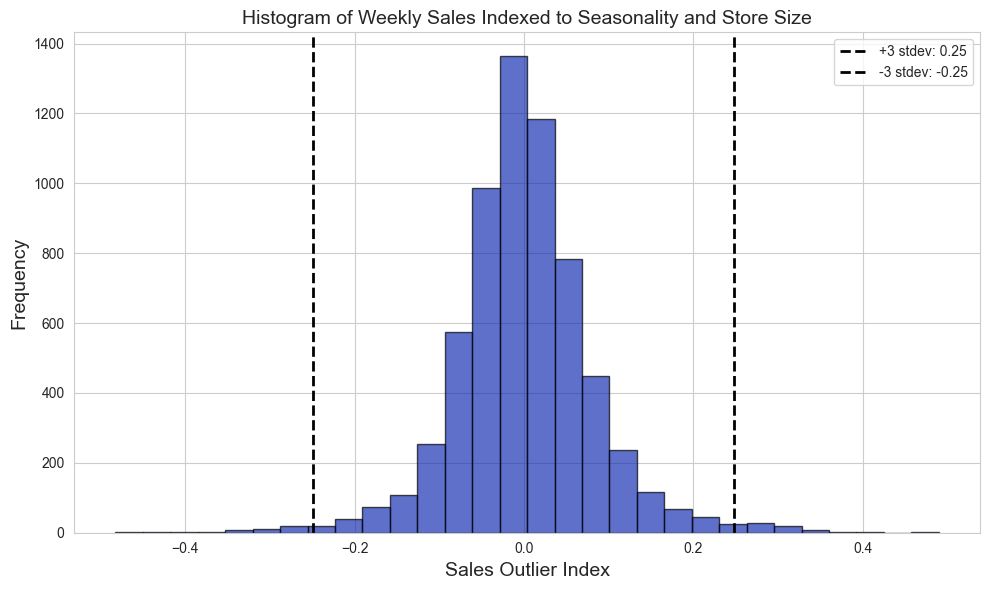

In [652]:
# Plotting the histogram of outlier index
plt.figure(figsize=(10, 6))
plt.hist(total_store_sales_index_copy['Outlier_Index'], bins=30, color=(0.1, 0.2, 0.7, 0.6), edgecolor='black', alpha=0.7)
plt.axvline(stdev_index*3, color='black', linestyle='dashed', linewidth=2, label=f'+3 stdev: {stdev_index*3:,.2f}')
plt.axvline(-stdev_index*3, color='black', linestyle='dashed', linewidth=2, label=f'-3 stdev: {-stdev_index*3:,.2f}')
plt.title("Histogram of Weekly Sales Indexed to Seasonality and Store Size", fontsize=14)
plt.xlabel("Sales Outlier Index", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(True)

# Format the x-axis to show dollar signs and avoid scientific notation
#ax = plt.gca()
#ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}%'))

plt.tight_layout()
plt.show()


Year on year sales histogram

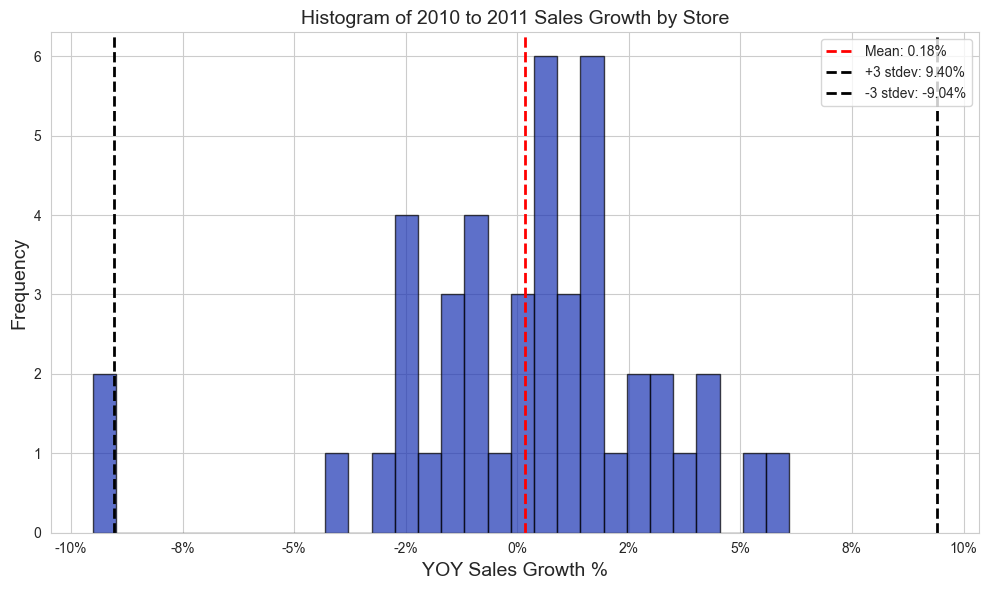

In [656]:
#creation of 2010 and 2011 sales values
total_store_sales_growth = total_store_sales.copy()
filtered_df_2010 = total_store_sales_growth[
    (total_store_sales_growth['Date'] >= '2010-02-05') &
    (total_store_sales_growth['Date'] < '2011-02-04')
].copy()

avg_2010_sales_by_store = avg_2010_sales_by_store = filtered_df_2010.groupby('Store')['Weekly_Sales'].mean().reset_index()
avg_2010_sales_by_store.columns = ['Store', 'avg_2010_sales']

filtered_df_2011 = total_store_sales_growth[
    (total_store_sales_growth['Date'] >= '2010-02-04') &
    (total_store_sales_growth['Date'] < '2012-02-03')
].copy()

avg_2011_sales_by_store = filtered_df_2011.groupby('Store')['Weekly_Sales'].mean().reset_index()
avg_2011_sales_by_store.columns = ['Store', 'avg_2011_sales']

#merge the 2011 table into the 2010 one for comparisons
avg_2010_sales_by_store = avg_2010_sales_by_store.merge(avg_2011_sales_by_store, on='Store')

#YOY sales growth creation
avg_2010_sales_by_store['yoy_growth'] = (avg_2010_sales_by_store['avg_2011_sales'] / avg_2010_sales_by_store['avg_2010_sales'] - 1)*100

#stdev and average growth used in the histogram
avg_growth = avg_2010_sales_by_store['yoy_growth'].mean()
stdev_growth = avg_2010_sales_by_store['yoy_growth'].std()

# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(avg_2010_sales_by_store['yoy_growth'], bins=30, color=(0.1, 0.2, 0.7, 0.6), edgecolor='black', alpha=0.7)
plt.axvline(avg_growth, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {avg_growth:,.2f}%')
plt.axvline(avg_growth + stdev_growth*3, color='black', linestyle='dashed', linewidth=2, label=f'+3 stdev: {avg_growth + stdev_growth*3:,.2f}%')
plt.axvline(avg_growth - stdev_growth*3, color='black', linestyle='dashed', linewidth=2, label=f'-3 stdev: {avg_growth - stdev_growth*3:,.2f}%')
plt.title("Histogram of 2010 to 2011 Sales Growth by Store", fontsize=14)
plt.xlabel("YOY Sales Growth %", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.legend()
plt.grid(True)

# Format the x-axis to show dollar signs and avoid scientific notation
ax = plt.gca()
ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: f'{x:,.0f}%'))

plt.tight_layout()
plt.show()




single line trendchart for single store

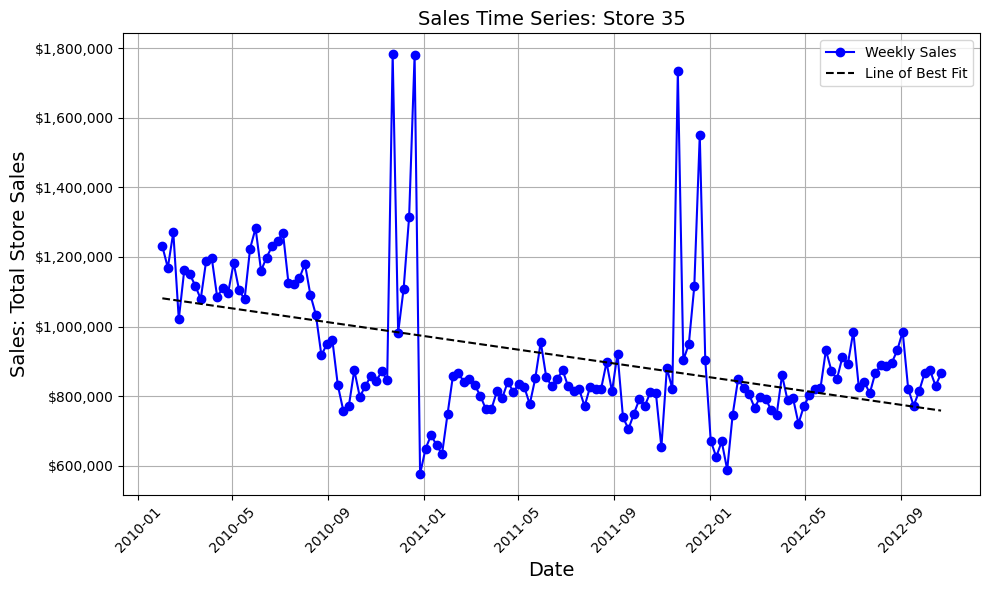

In [278]:
store_35_trend = total_store_sales.copy()
store_35_trend = store_35_trend[
    (total_store_sales_growth['Store'] == 35)
].copy()

trend_chart(store_35_trend, "Total Store Sales", store_set = "Store 35", trend_line=True)




In [ ]:
multiple line trendchart with trend lines

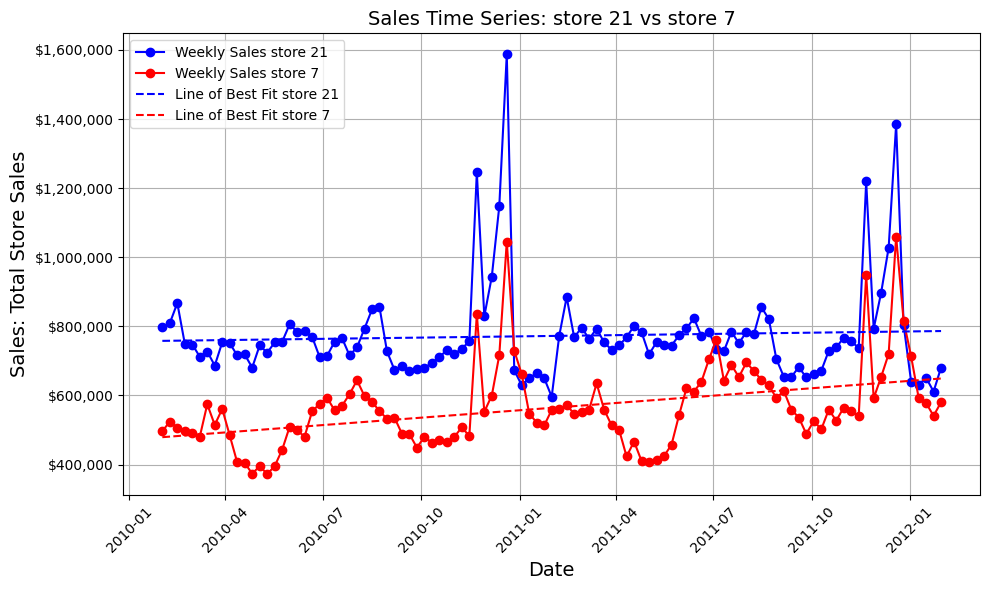

In [287]:
store_21_trend = total_store_sales[total_store_sales_growth['Store'] == 21].copy()
store_21_trend = store_21_trend[
    (store_21_trend['Date'] < '2012-02-04')
].copy()
store_7_trend = total_store_sales[total_store_sales_growth['Store'] == 7].copy()
store_7_trend = store_7_trend[
    (store_7_trend['Date'] < '2012-02-04')
].copy()

comparative_trend_chart(store_21_trend, store_7_trend, "Total Store Sales", "store 21", "store 7", trend_line=True)



measurement simulations results bar chart

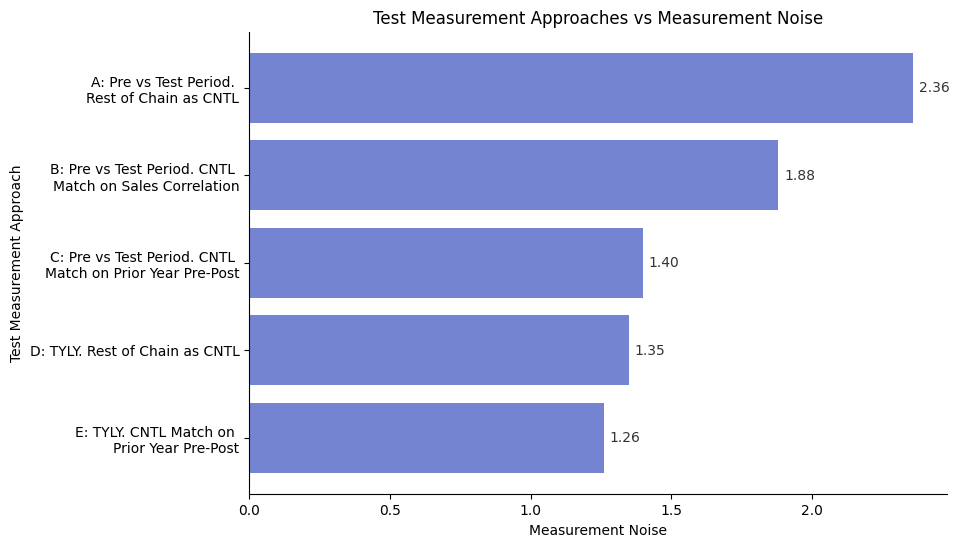

In [636]:
results_df = pd.DataFrame()
barchart_df_temp = pd.DataFrame({'test_params' : ['E: TYLY. CNTL Match on \nPrior Year Pre-Post'], 'Noise' : [0.0126]})
results_df = pd.concat([results_df, barchart_df_temp])
barchart_df_temp = pd.DataFrame({'test_params' : ['D: TYLY. Rest of Chain as CNTL'], 'Noise' : [0.0135]})
results_df = pd.concat([results_df, barchart_df_temp])
barchart_df_temp = pd.DataFrame({'test_params' : ['C: Pre vs Test Period. CNTL \nMatch on Prior Year Pre-Post'], 'Noise' : [0.014]})
results_df = pd.concat([results_df, barchart_df_temp])
barchart_df_temp = pd.DataFrame({'test_params' : ['B: Pre vs Test Period. CNTL \nMatch on Sales Correlation'], 'Noise' : [0.0188]})
results_df = pd.concat([results_df, barchart_df_temp])
barchart_df_temp = pd.DataFrame({'test_params' : ['A: Pre vs Test Period. \nRest of Chain as CNTL'], 'Noise' : [0.0236]})
results_df = pd.concat([results_df, barchart_df_temp])

import textwrap

plt.figure(figsize=(9, 6))  # Increase the figure width
bars = plt.barh(results_df['test_params'], results_df['Noise']*100, color=(0.1, 0.2, 0.7, 0.6))
plt.title("Test Measurement Approaches vs Measurement Noise", fontsize=12)
plt.ylabel("Test Measurement Approach", fontsize=10)
plt.xlabel("Measurement Noise", fontsize=10)
plt.xticks()

# Add text on top of the bars
for bar in bars:
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', 
             color=(0.0, 0.0, 0.0, 0.8), fontsize=10, va='center')

# Wrap the labels
#wrapped_labels = [textwrap.fill(label, 10) for label in results_df['test_params']]
#plt.yticks(ticks=range(len(results_df['test_params'])), labels=wrapped_labels)

# Adjust margins to create more space for y labels
#plt.subplots_adjust(left=0.2)  # Adjust this value as needed
#ax.set_xlim(left=25)  # Shift the zero line to the right, adjust this value as needed

# Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()


With and without outliers bar chart

                              test_params   Noise
0                 TYLY - Balance of Chain  0.0135
0  TYLY - Balance of Chain\nNo outliers\n  0.0112


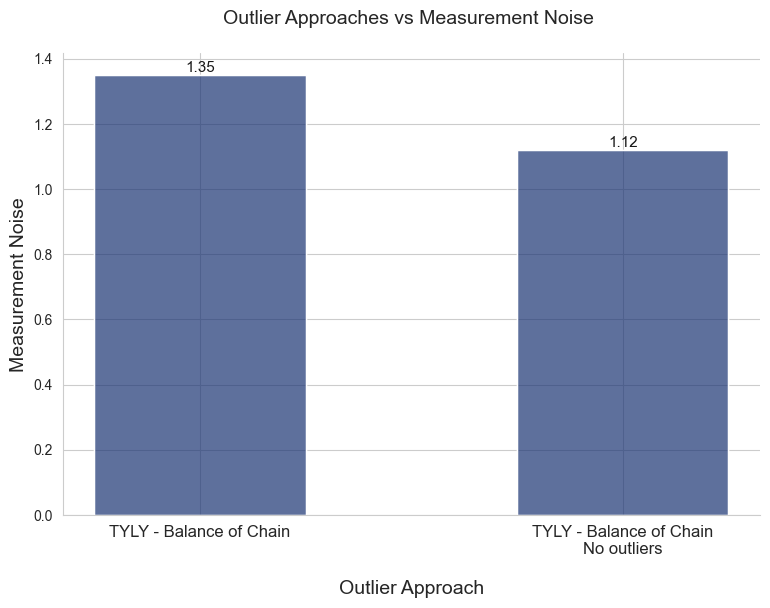

In [657]:
results_df = pd.DataFrame()
barchart_df_temp = pd.DataFrame({'test_params' : ['TYLY - Balance of Chain'], 'Noise' : [0.0135]})
results_df = pd.concat([results_df, barchart_df_temp])
barchart_df_temp = pd.DataFrame({'test_params' : ['TYLY - Balance of Chain\nNo outliers\n'], 'Noise' : [0.0112]})
results_df = pd.concat([results_df, barchart_df_temp])

print(results_df)

import textwrap

plt.figure(figsize=(9, 6))
plt.bar(results_df['test_params'], results_df['Noise']*100, color=(0.1, 0.2, 0.45, 0.45), width=0.5)
plt.title("Outlier Approaches vs Measurement Noise \n  ", fontsize=14)
plt.xlabel("Outlier Approach", fontsize=14)
plt.ylabel("Measurement Noise", fontsize=14)
plt.xticks(fontsize = 12)
bars = plt.bar(results_df['test_params'], results_df['Noise']*100, color=(0.1, 0.2, 0.45, 0.45), width=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=11, color =(0.0, 0.0, 0.0, 0.9))
    
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()


measurement approach, fewer stores comparison

                                      test_params   Noise
0      E: 3 Store Test: TYLY \nvs Matched Control  0.0176
0      E: 4 Store Test: TYLY \nvs Matched Control  0.0150
0      E: 5 Store Test: TYLY \nvs Matched Control  0.0135
0      E: 6 Store Test: TYLY \nvs Matched Control  0.0126
0  A: Pre vs Test Period. \nRest of Chain as CNTL  0.0236


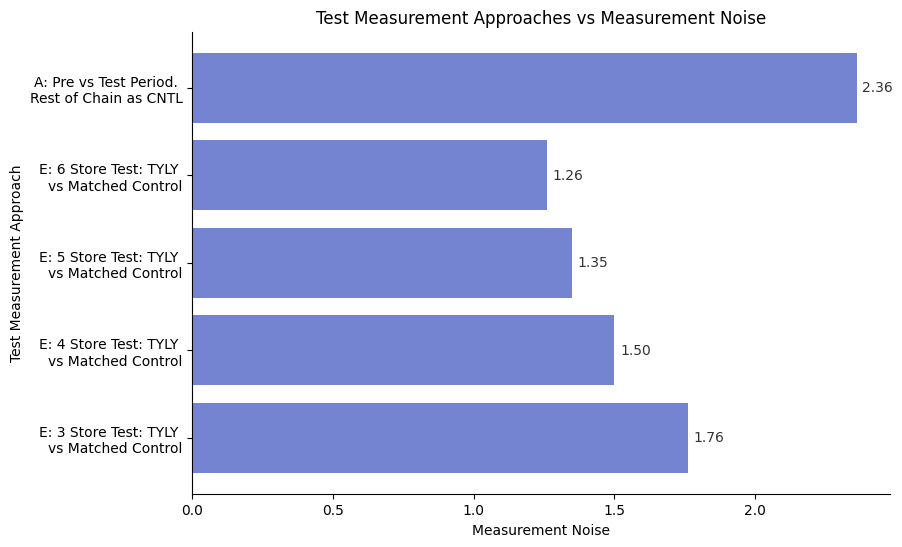

In [626]:
results_df = pd.DataFrame()
barchart_df_temp = pd.DataFrame({'test_params' : ['E: 3 Store Test: TYLY \nvs Matched Control'], 'Noise' : [0.0176]})
results_df = pd.concat([results_df, barchart_df_temp])
barchart_df_temp = pd.DataFrame({'test_params' : ['E: 4 Store Test: TYLY \nvs Matched Control'], 'Noise' : [0.0150]})
results_df = pd.concat([results_df, barchart_df_temp])
barchart_df_temp = pd.DataFrame({'test_params' : ['E: 5 Store Test: TYLY \nvs Matched Control'], 'Noise' : [0.0135]})
results_df = pd.concat([results_df, barchart_df_temp])
barchart_df_temp = pd.DataFrame({'test_params' : ['E: 6 Store Test: TYLY \nvs Matched Control'], 'Noise' : [0.0126]})
results_df = pd.concat([results_df, barchart_df_temp])
barchart_df_temp = pd.DataFrame({'test_params' : ['A: Pre vs Test Period. \nRest of Chain as CNTL'], 'Noise' : [0.0236]})
results_df = pd.concat([results_df, barchart_df_temp])

print(results_df)


plt.figure(figsize=(9, 6))  # Increase the figure width
bars = plt.barh(results_df['test_params'], results_df['Noise']*100, color=(0.1, 0.2, 0.7, 0.6))
plt.title("Test Measurement Approaches vs Measurement Noise", fontsize=12)
plt.ylabel("Test Measurement Approach", fontsize=10)
plt.xlabel("Measurement Noise", fontsize=10)
plt.xticks()

# Add text on top of the bars
for bar in bars:
    plt.text(bar.get_width() + 0.02, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.2f}', 
             color=(0.0, 0.0, 0.0, 0.8), fontsize=10, va='center')

# Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

Printout of outlier index sorted by index value

In [398]:
datapoint_count = total_store_sales_index_copy.shape[0]

total_store_sales_index_neg_outliers = total_store_sales_index_copy[(total_store_sales_index_copy['Outlier_Index'] < -0.25)].copy()
total_store_sales_index_pos_outliers = total_store_sales_index_copy[(total_store_sales_index_copy['Outlier_Index'] > 0.25)].copy()
total_store_sales_index_neg_outliers_no_holiday = total_store_sales_index_neg_outliers[(total_store_sales['Date'] != '2010-12-20') & (total_store_sales['Date'] != '2010-12-13') & (total_store_sales['Date'] != '2010-11-22') & (total_store_sales['Date'] != '2011-11-21') & (total_store_sales['Date'] != '2011-12-19') & (total_store_sales['Date'] != '2011-12-12') & (total_store_sales['Date'] != '2010-11-26') & (total_store_sales['Date'] != '2010-12-03')].copy()
total_store_sales_index_pos_outliers_no_holiday = total_store_sales_index_pos_outliers[(total_store_sales['Date'] != '2010-12-20') & (total_store_sales['Date'] != '2010-12-13') & (total_store_sales['Date'] != '2010-11-22') & (total_store_sales['Date'] != '2011-11-21') & (total_store_sales['Date'] != '2011-12-19') & (total_store_sales['Date'] != '2011-12-12') & (total_store_sales['Date'] != '2010-11-26') & (total_store_sales['Date'] != '2010-12-03')].copy()

total_store_sales_index_neg_outliers_no_holiday.sort_values(by='Outlier_Index')

outlier_count = total_store_sales_index_neg_outliers_no_holiday.shape[0] + total_store_sales_index_pos_outliers.shape[0]

print(total_store_sales_index_neg_outliers_no_holiday.sort_values(by='Outlier_Index'))

           Date  Store  Weekly_Sales  Store_Avg_Sales  Week_Avg_Sales  \
3707 2011-08-29     18     540922.94     1.084718e+06    1.008369e+06   
591  2010-05-03      7     395453.83     5.706173e+05    1.077850e+06   
636  2010-05-10      7     372673.61     5.706173e+05    1.007335e+06   
2850 2011-04-18     16     368600.00     5.192477e+05    1.081704e+06   
4129 2011-10-31     35     653468.75     9.197250e+05    1.081234e+06   
546  2010-04-26      7     373655.61     5.706173e+05    9.712250e+05   
4355 2011-12-05     36     312298.37     3.735120e+05    1.234692e+06   
2931 2011-05-02      7     407012.47     5.706173e+05    1.041377e+06   
681  2010-05-17      7     395195.65     5.706173e+05    1.002669e+06   
2149 2010-12-27     35     576332.05     9.197250e+05    8.985004e+05   
6290 2012-10-01     36     277137.86     3.735120e+05    1.057036e+06   
456  2010-04-12      7     406228.19     5.706173e+05    1.004081e+06   
206  2010-03-01     27    1313729.72     1.775216e+

/var/folders/d8/81qn_kfs39x88w0868hpns480000gn/T/ipykernel_39155/1201103318.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  total_store_sales_index_neg_outliers_no_holiday = total_store_sales_index_neg_outliers[(total_store_sales['Date'] != '2010-12-20') & (total_store_sales['Date'] != '2010-12-13') & (total_store_sales['Date'] != '2010-11-22') & (total_store_sales['Date'] != '2011-11-21') & (total_store_sales['Date'] != '2011-12-19') & (total_store_sales['Date'] != '2011-12-12') & (total_store_sales['Date'] != '2010-11-26') & (total_store_sales['Date'] != '2010-12-03')].copy()
/var/folders/d8/81qn_kfs39x88w0868hpns480000gn/T/ipykernel_39155/1201103318.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  total_store_sales_index_pos_outliers_no_holiday = total_store_sales_index_pos_outliers[(total_store_sales['Date'] != '2010-12-20') & (total_store_sales['Date'] != '2010-12-13') & (total_store_sales['Date'] != '2010-11-2

Print the outlier trend charts

6435
29
3


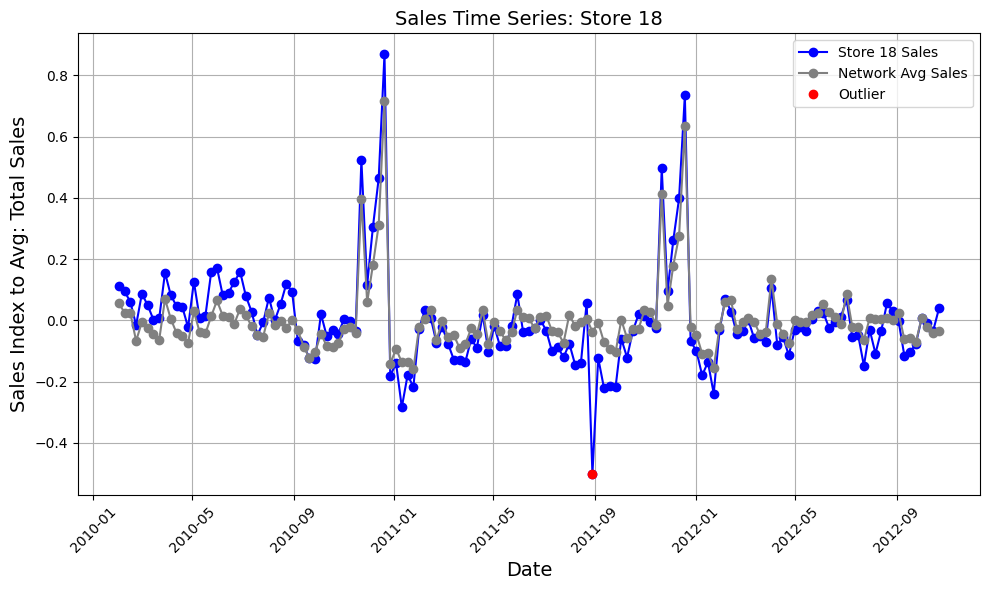

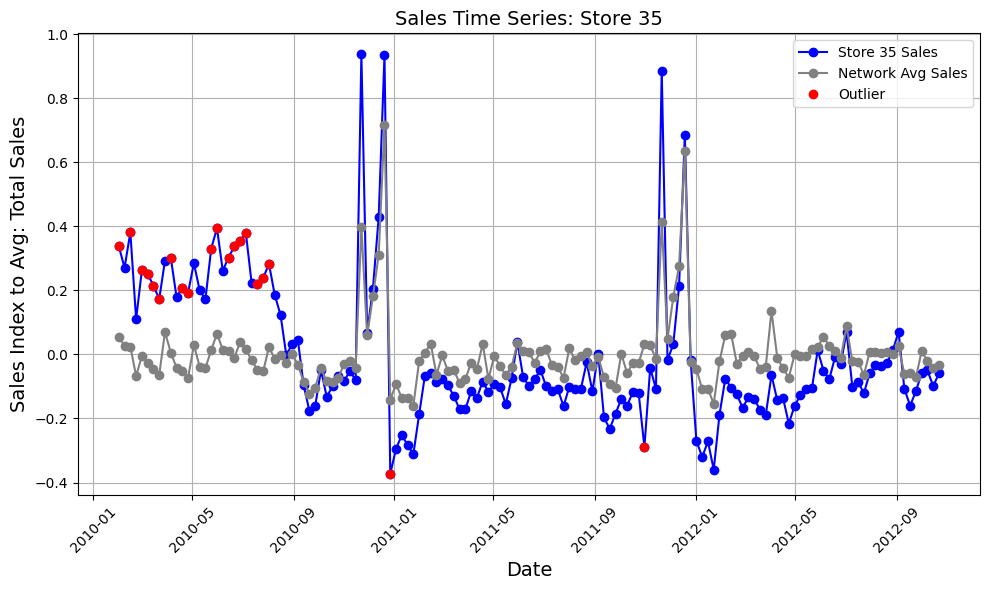

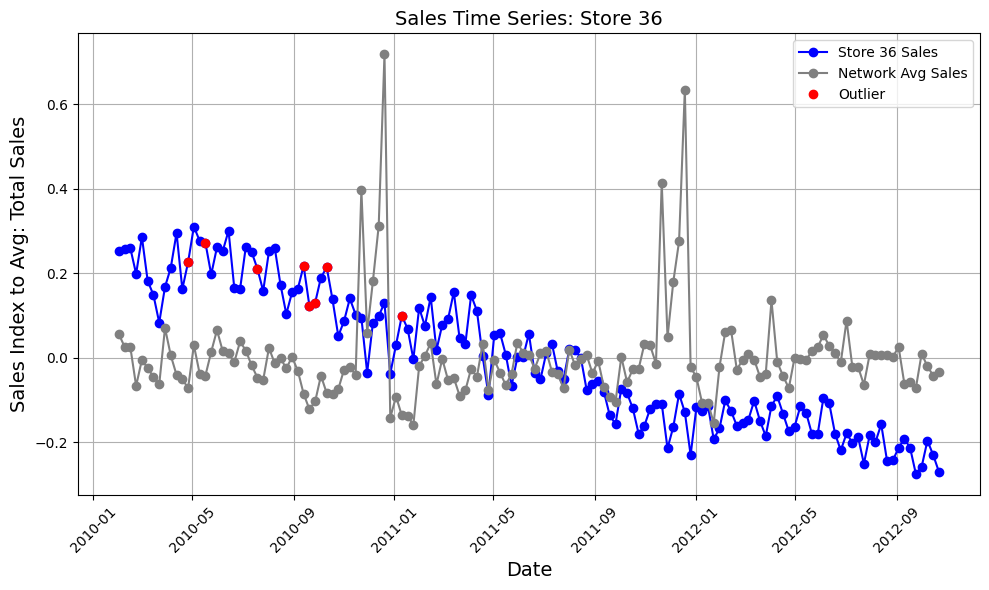

In [508]:
#print the outlier trend charts
total_store_sales_index_outliers = total_store_sales_index_copy[(total_store_sales_index_copy['Outlier_Flag'] == True)].copy()

#total_store_sales_index_outliers = total_store_sales_index_copy[(total_store_sales_index_copy['Outlier_Abs'] > 0.25)].copy()
print(total_store_sales_index_copy.shape[0])
print(total_store_sales_index_outliers.shape[0])

stores_outliers_df = (list(set(total_store_sales_index_outliers['Store'])))
print(len(outliers_list))

avg_sales = total_store_sales['Weekly_Sales'].mean()
plot_df = total_store_sales_index_copy.copy()
plot_df['Weekly_Sales'] = plot_df['Weekly_Sales'] / avg_sales - 1
for store_results in outliers_list:
    store_trend = total_store_sales_index_copy[total_store_sales_index_copy['Store'] == store_results.store].copy()
    store_trend['Weekly_Sales'] = store_trend['Weekly_Sales'] / store_trend['Store_Avg_Sales'] - 1
    outlier_trend_chart_comparison(store_trend, plot_df, "Total Sales", store_set=f"Store {store_results.store}", outlier_dates = store_results.outlier_dates)




Adjusting the store 18 outlier back to normal values

/var/folders/d8/81qn_kfs39x88w0868hpns480000gn/T/ipykernel_39155/2547476577.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_store_sales_no_outliers['Weekly_Sales'].loc[(total_store_sales_no_outliers['Store'] == 18) & (total_store_sales_no_outliers['Date'] == '2011-08-29')] = total_store_sales_no_outliers['Weekly_Sales'].loc[(total_store_sales_no_outliers['Store'] == 18) & (total_store_sales_no_outliers['Date'] == '2011-08-29')] / 0.5


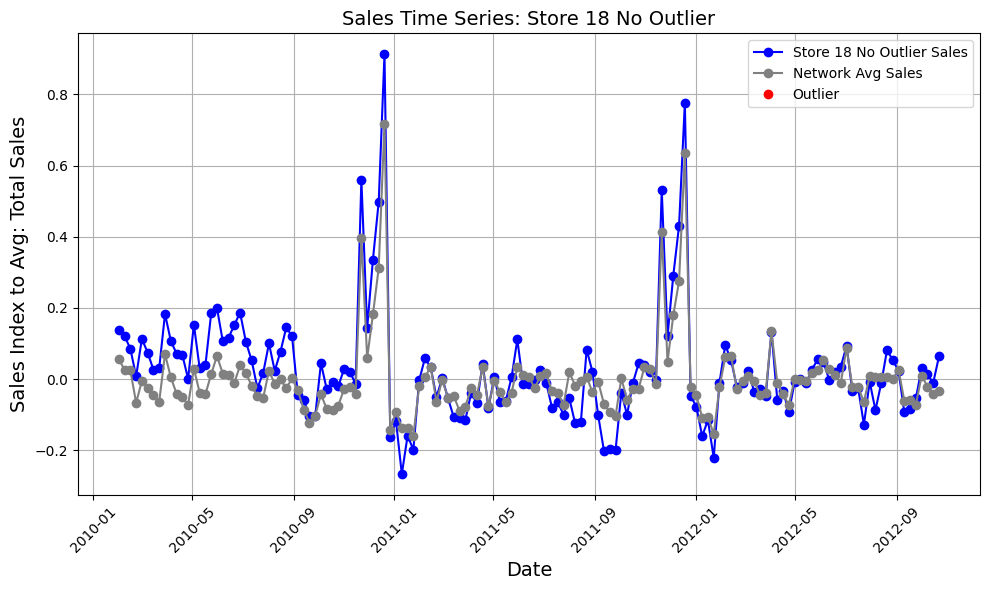

In [519]:
total_store_sales_no_outliers = total_store_sales.loc[(total_store_sales['Store'] != 35) & (total_store_sales['Store'] != 36)].copy()
#adjustment div by 0.5
total_store_sales_no_outliers['Weekly_Sales'].loc[(total_store_sales_no_outliers['Store'] == 18) & (total_store_sales_no_outliers['Date'] == '2011-08-29')] = total_store_sales_no_outliers['Weekly_Sales'].loc[(total_store_sales_no_outliers['Store'] == 18) & (total_store_sales_no_outliers['Date'] == '2011-08-29')] / 0.5
plot_df = total_store_sales_index_copy.copy()
plot_df['Weekly_Sales'] = plot_df['Weekly_Sales'] / avg_sales - 1
store_trend = total_store_sales_no_outliers[total_store_sales_no_outliers['Store'] == 18].copy()
store_trend['Weekly_Sales'] = store_trend['Weekly_Sales'] / 1060000 - 1
outlier_trend_chart_comparison(store_trend, plot_df, "Total Sales", store_set=f"Store 18 No Outlier", outlier_dates = [])


bar chart showing comparison to 5 store tests with outliers removed

                                         test_params   Noise
0            TYLY - Balance of Chain \n6 test stores  0.0135
0  TYLY - Balance of Chain\nNo outliers 6 test st...  0.0112
0  TYLY - Balance of Chain\nNo outliers 5 test st...  0.0129


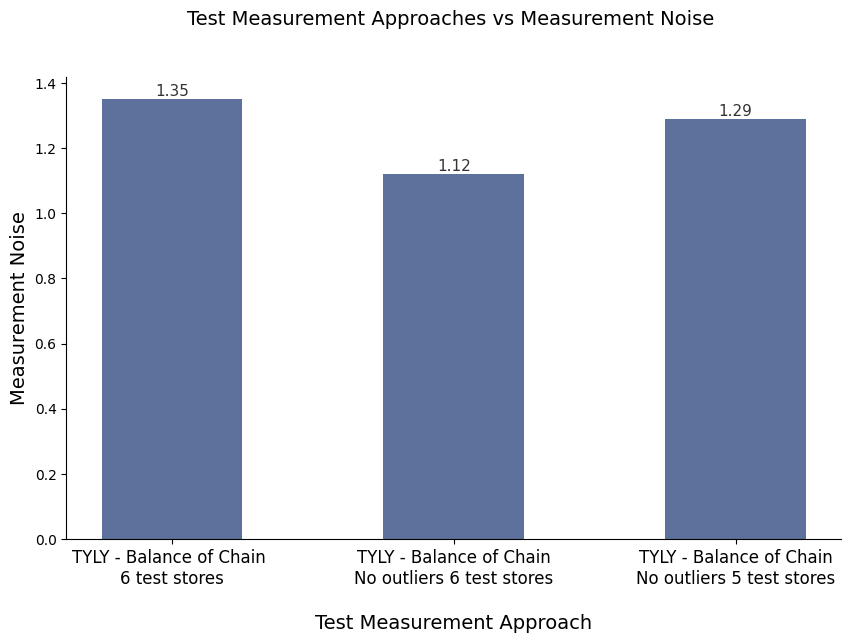

In [644]:
#outliers fewer sites barchart

results_df = pd.DataFrame()
barchart_df_temp = pd.DataFrame({'test_params' : ['TYLY - Balance of Chain \n6 test stores'], 'Noise' : [0.0135]})
results_df = pd.concat([results_df, barchart_df_temp])
barchart_df_temp = pd.DataFrame({'test_params' : ['TYLY - Balance of Chain\nNo outliers 6 test stores\n'], 'Noise' : [0.0112]})
results_df = pd.concat([results_df, barchart_df_temp])
barchart_df_temp = pd.DataFrame({'test_params' : ['TYLY - Balance of Chain\nNo outliers 5 test stores'], 'Noise' : [0.0129]})
results_df = pd.concat([results_df, barchart_df_temp])

print(results_df)

plt.figure(figsize=(10, 6))
plt.bar(results_df['test_params'], results_df['Noise']*100, color=(0.1, 0.2, 0.45, 0.45), width=0.5)
plt.title("Test Measurement Approaches vs Measurement Noise \n\n  ", fontsize=14)
plt.xlabel("Test Measurement Approach", fontsize=14)
plt.ylabel("Measurement Noise", fontsize=14)
plt.xticks(fontsize = 12)
bars = plt.bar(results_df['test_params'], results_df['Noise']*100, color=(0.1, 0.2, 0.45, 0.45), width=0.5)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{height:.2f}', ha='center', va='bottom', fontsize=11, color =(0.0, 0.0, 0.0, 0.8))
    
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()
